In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
#from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\15132\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df=pd.read_csv('twitter.csv',encoding = 'latin',header=None)

In [3]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [4]:
df.rename({0:'target',1:'ids',2:'date',3:'flag',4:'user',5:'tweet'}, axis='columns',inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.shape

(1600000, 6)

In [7]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [8]:
df[df['target']==4].loc[800001,'tweet']
#Positive Tweet

'im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!'

In [9]:
df[df['target']==0].loc[799999,'tweet']
#Negative Tweet

'has to resit exams over summer...  wishes he worked harder at first year of uni...'

In [10]:
df['tweet'].nunique()

1581466

In [11]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
tweet     1581466
dtype: int64

In [12]:
df['tweet'].drop_duplicates(inplace=True)

In [13]:
df['tweet']

0          @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1              is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
2                                    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
3                                                                              my whole body feels itchy and like its on fire 
4              @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
                                                                  ...                                                         
1599995                                                               Just woke up. Having no school is the best feeling ever 
1599996                                         TheWDB.com - Very cool to hear old Walt interviews!  â« http:/

In [14]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [15]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['tweet'], '@[\w]*')

In [16]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])

In [17]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

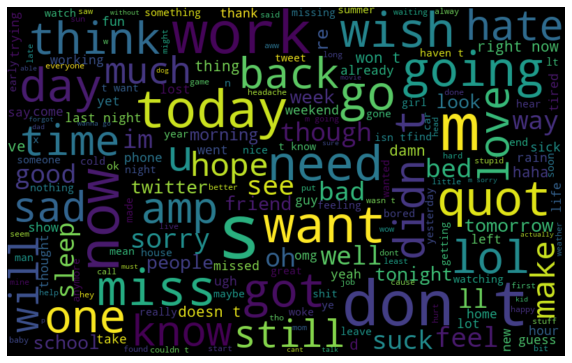

In [18]:
# create text from negative tweets
all_words = ' '.join([text for text in df['Tweet'][df['target']==0]])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

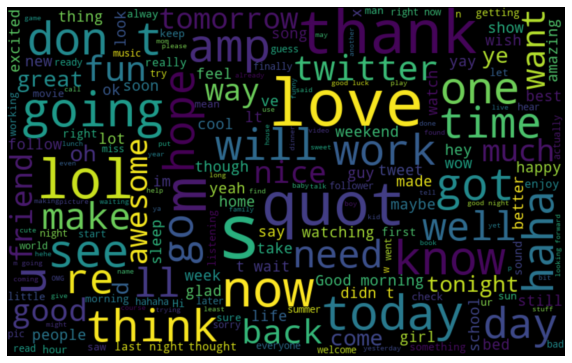

In [19]:
# create text from positive tweets
all_words = ' '.join([text for text in df['Tweet'][df['target']==4]])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, cmap='gray',interpolation='gaussian')
plt.axis('off')
plt.show()

In [20]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [21]:
# extracting hashtags
Hash_Positive = hashtag_extract(df['tweet'][df['target'] == 4])
Hash_Negative = hashtag_extract(df['tweet'][df['target'] == 0])

In [22]:
Hash_Positive=sum(Hash_Positive,[])

In [23]:
#print(Hash_Positive)

In [24]:
Hash_Negative=sum(Hash_Negative,[])

In [25]:
#print(Hash_Negative)

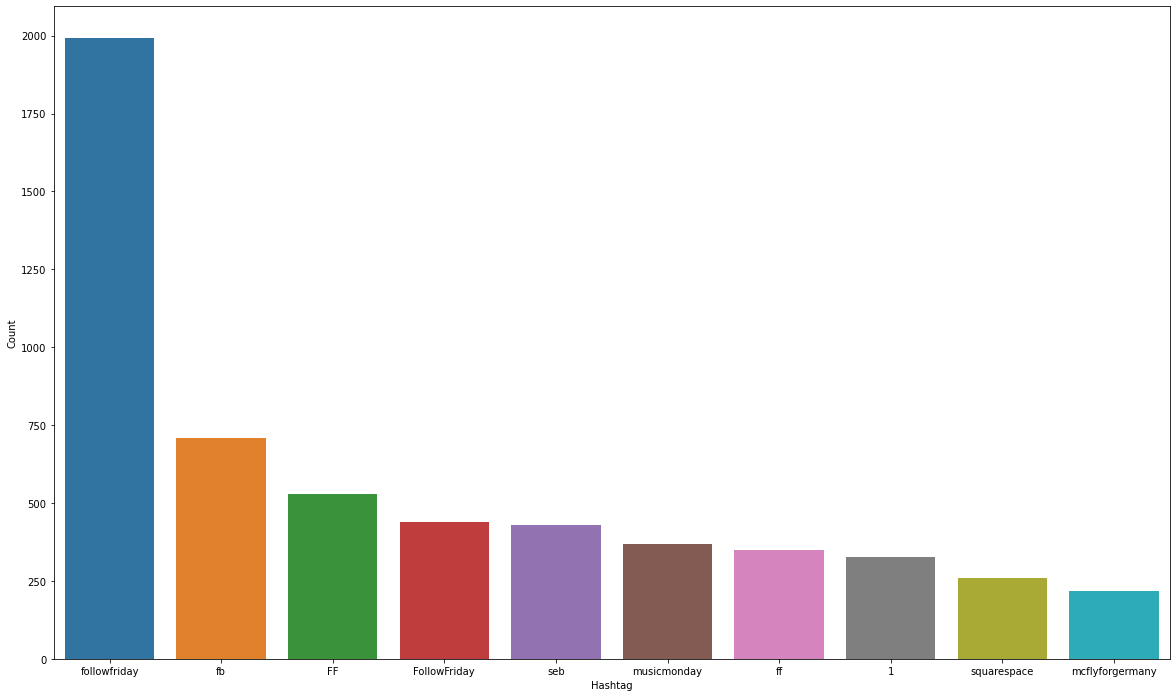

In [26]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(Hash_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (20,12))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

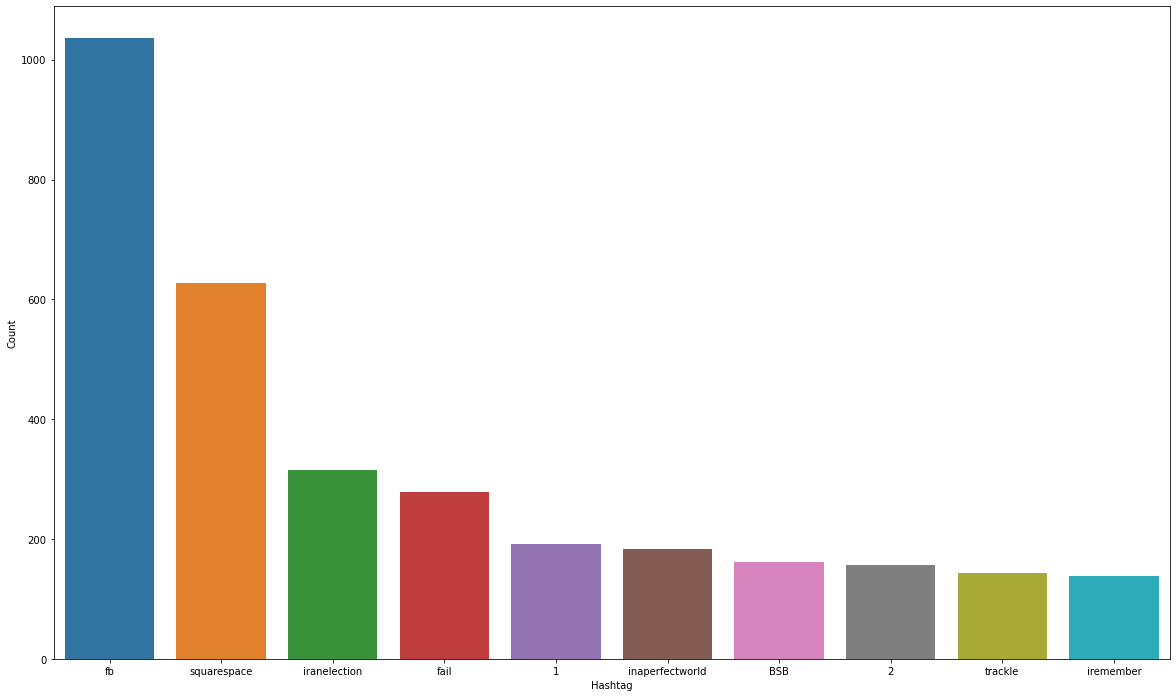

In [27]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(Hash_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (20,12))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

In [28]:
F_df=df[['target','Tweet']]

In [29]:
F_df

,target,Tweet
0,0,
1,0,is upset that he can t update his Facebook by texting it and might cry as a result School today also Blah
2,0,I dived many times for the ball Managed to save The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i here because I can t see you all over there
...,...,...
1599995,4,Just woke up Having no school is the best feeling ever
1599996,4,TheWDB com Very cool to hear old Walt interviews
1599997,4,Are you ready for your MoJo Makeover Ask me for details
1599998,4,Happy th Birthday to my boo of alll time Tupac Amaru Shakur


In [30]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

In [31]:
train, test = train_test_split(F_df, test_size = 0.30, stratify = F_df['target'], random_state=121)

train.shape,test.shape

((1120000, 2), (480000, 2))

In [32]:
tfidf_vectorizer = TfidfVectorizer(lowercase= True, max_features=1000, stop_words=ENGLISH_STOP_WORDS)

# fit the object with the training data tweets
tfidf_vectorizer.fit(train.Tweet)

TfidfVectorizer(max_features=1000,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [34]:
train_idf = tfidf_vectorizer.transform(train.Tweet)
test_idf  = tfidf_vectorizer.transform(test.Tweet)

In [35]:
test_idf.shape

(480000, 1000)

In [36]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(train_idf,train.target)

NB_prediction = naiveByes_clf.predict(test_idf)
NB_accuracy = accuracy_score(test.target,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(train_idf,train.target))
print("testing accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,test.target))
print(confusion_matrix(y_true= test.target, y_pred= NB_prediction))

training accuracy Score    :  0.7235892857142857
testing accuracy Score :  0.7239145833333334
              precision    recall  f1-score   support

           0       0.75      0.71      0.73    251361
           4       0.70      0.74      0.72    228639

    accuracy                           0.72    480000
   macro avg       0.72      0.72      0.72    480000
weighted avg       0.73      0.72      0.72    480000

[[179420  60580]
 [ 71941 168059]]


In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(train_idf,train.target)

logreg_prediction = logreg.predict(test_idf)
logreg_accuracy = accuracy_score(test.target,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(train_idf,train.target))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,test.target))
print(confusion_matrix(y_true= test.target, y_pred= logreg_prediction))

Training accuracy Score    :  0.7402839285714286
Testing accuracy Score :  0.7407916666666666
              precision    recall  f1-score   support

           0       0.70      0.76      0.73    220308
           4       0.78      0.72      0.75    259692

    accuracy                           0.74    480000
   macro avg       0.74      0.74      0.74    480000
weighted avg       0.74      0.74      0.74    480000

[[167944  72056]
 [ 52364 187636]]


In [43]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(lowercase=True,
                                                      max_features=1000,
                                                      stop_words= ENGLISH_STOP_WORDS)),
                            ('model', LogisticRegression())])

# fit the pipeline model with the training data                            
pipeline.fit(train.Tweet, train.target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
           

In [55]:
#negative tweet example (Trumps' tweet)
ntext = ["I am not trying to get top level Security for my Children. This was typically a False News."]

In [59]:
#positive tweet example (Hilarys' tweet)
ptext = ["Looking Forward to honoring some brave young people tonight at @ChildDefender where i started my career."]

In [57]:
# predict the label using the pipeline for logreg-model
pipeline.predict(ntext)

array([0], dtype=int64)

In [60]:
# predict the label using the pipeline
pipeline.predict(ptext)

array([4], dtype=int64)

In [47]:
pipeline1 = Pipeline(steps= [('tfidf', TfidfVectorizer(lowercase=True,
                                                      max_features=1000,
                                                      stop_words= ENGLISH_STOP_WORDS)),
                            ('model', MultinomialNB())])

# fit the pipeline model with the training data                            
pipeline1.fit(train.Tweet, train.target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
           

In [58]:
pipeline1.predict(ntext)

array([0], dtype=int64)

In [61]:
pipeline1.predict(ptext)

array([4], dtype=int64)

## Class 0 is for Negative Tweets and Class 4 is for Positive Tweets